<a href="https://colab.research.google.com/github/aritrasen87/LLM_RAG_Model_Deployment/blob/main/LangGraph_8_StructuredOutput_FromAgents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#required installations
! pip install langgraph langchain_community --q
! pip install langchain_openai --q

In [ ]:
# Key and llm initialization
import os
from google.colab import userdata
from langchain_openai import ChatOpenAI

# Now you can access your environment variables using os.environ
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY')

llm = ChatOpenAI(model="gpt-4o-mini")

In [ ]:
# Tavily tool initialization
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)

In [ ]:
from pydantic import BaseModel, Field
from typing import  Literal
from langchain_core.tools import tool
from langgraph.graph import MessagesState

# Pydantic object for structed output
class CityDetails(BaseModel):
    """Respond to the user with this"""
    state_name: str = Field(description="State name of the city")
    state_capital: str = Field(description="State capital of the city")
    country_name: str = Field(description="Country name of the city")
    country_capital: str = Field(description="Country capital of the city")


# Inherit 'messages' key from MessagesState, which is a list of chat messages
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: CityDetails

# Python function to tool creation
@tool
def get_city_details(prompt):
    "Should do a web search to find the required city details"
    response = tavily_tool.invoke(prompt)
    return response

tools = [get_city_details]

# two LLM models
model_with_tools = llm.bind_tools(tools)
model_with_structured_output = llm.with_structured_output(CityDetails)

In [ ]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

# Define the function that calls the model
def call_model(state: AgentState):
    response = model_with_tools.invoke(state['messages'])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the function that responds to the user
def respond(state: AgentState):
    response = model_with_structured_output.invoke([HumanMessage(content=state['messages'][-2].content)])
    # We return the final answer
    return {"final_response": response}

# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue
    else:
        return "continue"

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

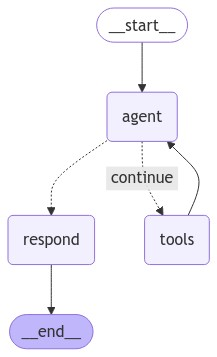

In [ ]:
from IPython.display import Image, display
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
answer = graph.invoke(input={"messages": [("human", "Tell me about the city details for Kolkata?")]})['final_response']

In [ ]:
answer

CityDetails(state_name='West Bengal', state_capital='Kolkata', country_name='India', country_capital='New Delhi')

In [ ]:
for s in graph.stream({
        "messages": [HumanMessage(content="Tell me about the city details for Kolkata?")]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gxxvXonYq3LU9tvcHHyljXlZ', 'function': {'arguments': '{"prompt":"Kolkata"}', 'name': 'get_city_details'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 59, 'total_tokens': 76, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_483d39d857', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6dae51cb-145c-404b-8369-3d82da930665-0', tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'Kolkata'}, 'id': 'call_gxxvXonYq3LU9tvcHHyljXlZ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 59, 'output_tokens': 17, 'total_tokens': 76})]}}
----
{'tools': {'messages': [ToolMessage(content='[{"url": "https://www.britannica.com/place/Kolkata", "content": "Kolkata (formerly Calcutta), city, capital of West Bengal state, and former capital (1772-1911) o